By Jack Allen  s3832293

Sources: A lot of the functions and graphs have been taken from the weekly labs and altered to fit the purpose of this task

This portion of the notebook will aim to develop a model that can detect if a cell is cancerous from an image of a cell.

importing modules and loading the dataset

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv('./data_labels_mainData.csv')



Now I will begin EDA, I'll start by checking the datatypes

In [2]:
data.dtypes

InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
dtype: object

The datatypes are fine and don't need to be changed, next we need to check for missing values

In [3]:
data.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

There are no missing values for the rest of EDA I'll split the dataset randomly into test, train and validation

In [4]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


We need to look at how the train and test data is distributed

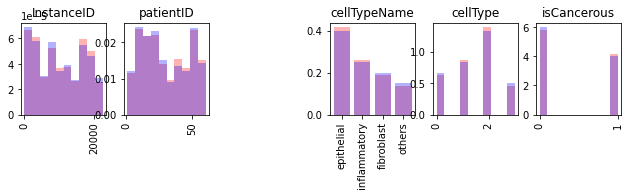

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
for i, col in enumerate(train_data.columns):

    if col != 'ImageName':
        plt.subplot(10,11,i+1)
        if train_data[col].dtypes != np.int64:
            plt.bar(train_data[col].value_counts().index.astype(str), 
                    train_data[col].value_counts().values/np.sum(train_data[col].value_counts().values), 
                    alpha=0.3, color='r')
            plt.bar(test_data[col].value_counts().index.astype(str), 
                    test_data[col].value_counts().values/np.sum(test_data[col].value_counts().values), 
                    alpha=0.3, color='b')
        else:
            plt.hist(train_data[col], alpha=0.3, color='r', density=True)
            plt.hist(test_data[col], alpha=0.3, color='b', density=True)

        plt.title(col)
        plt.xticks(rotation='vertical')

The train and test sets seem pretty equally distributed

Data Preprocessing

We don't need to use the InstanceID, patientID, cellTypeName or cellType as we are focussing on the isCancerous attribute

In [6]:
train_data = train_data.drop(['InstanceID', 'patientID', 'cellTypeName', 'cellType'], axis=1)
test_data = test_data.drop(['InstanceID', 'patientID', 'cellTypeName', 'cellType'], axis=1)
val_data = val_data.drop(['InstanceID', 'patientID', 'cellTypeName', 'cellType'], axis=1)

Model Development

I have decided that the performance metric accuracy will be used for this task based off the EDA and because false positives and false negatives are equally important, and accuracy is best used when that is the case.

For a traditional NN an accuracy of 50% is realistically atainable so this will be the target

## traditional Neural Network

learning curve function

In [7]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

I'll begin by using a multi-layer preceptron. And setting some parameters

In [8]:
INPUT_DIM = (32,32,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 1

I'll be using the Sequential API to build this model because it is the simplest

flattening the images for later use

In [9]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               786688    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 786,945
Trainable params: 786,945
Non-trainable params: 0
_________________________________________________________________


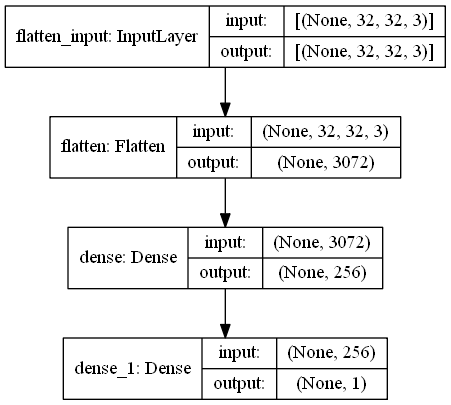

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

The loss function used will be Binary Cross Entropy because there is only two options for the images (cancerous and not cancerous).

The metric will be binary accuracy for the same reason as above

In [11]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy'])

The model can now be trained

I will begin by storing the labels in string format
and loading the set of images

In [12]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='binary')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.


Now we can train the model

In [14]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

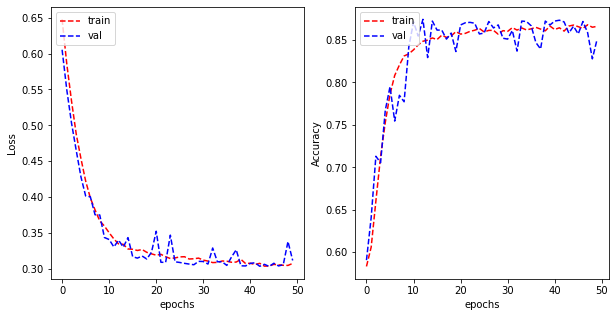

In [15]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['binary_accuracy'], history.history['val_binary_accuracy'], 
                    metric_name='Accuracy')

In [16]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='binary')

Found 1980 validated image filenames belonging to 2 classes.


In [17]:
model.evaluate(test_generator)

1980/1980 [==============================] - 1s 622us/step - loss: 0.3140 - binary_accuracy: 0.8444


[0.3139912486076355, 0.8444444537162781]

an accuracy of 0.85 is much better than expected. This model performed very well for a traditional NN

### Visualising the output


In [18]:
label_names = {'nc' : 0, 'c' : 1}

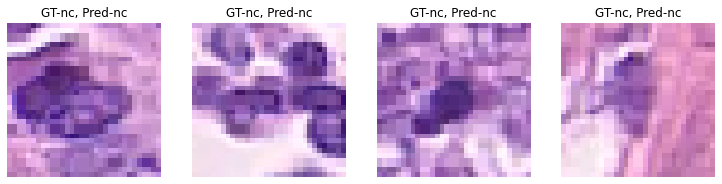

In [19]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

The traditional NN performed well much better than the accuracy target but a deep neural network could possibly perform better.

## improving the accuracy through use of a deep neural network



In [20]:
import tensorflow as tf


model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [21]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['binary_accuracy'])

In [22]:
history_VGG_1 = model_VGG_1.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

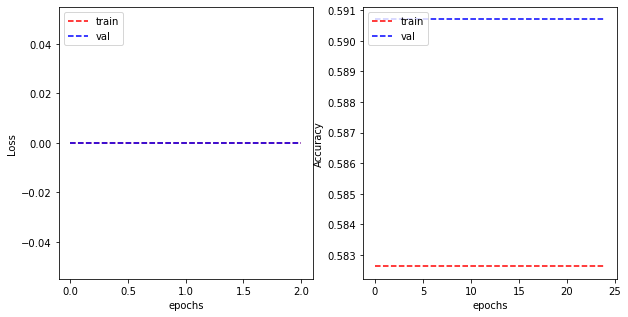

In [23]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['binary_accuracy'], history_VGG_1.history['val_binary_accuracy'], 
                    metric_name='Accuracy')

In [24]:
reg_lambda = 0.001

model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [27]:
model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['binary_accuracy'])

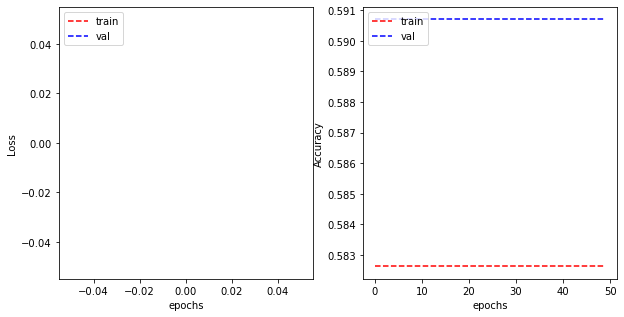

In [28]:
history_VGG_2 = model_VGG_2.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

plot_learning_curve(history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['binary_accuracy'], history_VGG_2.history['val_binary_accuracy'], 
                    metric_name='Accuracy')